# Creating a weather Index

Import the required modules.

In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from pathlib import Path

Read the csv containing the city temperature data. The data comes from "the University of Dayton - Environmental Protection Agency Average Daily Temperature Archive". Access the data here: https://www.kaggle.com/datasets/sudalairajkumar/daily-temperature-of-major-cities?resource=download. It was accessed and downloaded on 21/10/2022.

In [3]:
read_temp_path = Path("__file__").parent.joinpath("Raw_Data", "Weather_Data").parent.joinpath("Weather_Data", "city_temperature.csv")
df = pd.read_csv(read_temp_path)
#print(read_temp_path)

C:\Users\rafir\AppData\Local\Temp\ipykernel_10368\3101557854.py:2: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(read_temp_path)


Have a look at the data

In [4]:
df.head()

,Region,Country,State,City,Month,Day,Year,AvgTemperature
0,Africa,Algeria,NaN,Algiers,1,1,1995,64.2
1,Africa,Algeria,NaN,Algiers,1,2,1995,49.4
2,Africa,Algeria,NaN,Algiers,1,3,1995,48.8
3,Africa,Algeria,NaN,Algiers,1,4,1995,46.4
4,Africa,Algeria,NaN,Algiers,1,5,1995,47.9


Clean the data so we only use cities in Europe and  after 2012. Also compile the month, day and year columns into one date column and then drop all extra columns such as state, month, day and year.

In [5]:
df = df[(df.Region == "Europe") & (df.Year >= 2012)]  
cols=["Month","Day","Year"]
df['Date'] = df[cols].apply(lambda x: '-'.join(x.values.astype(str)), axis="columns")
df['Date']=pd.to_datetime(df['Date'])
df = df.drop(df.columns[[2,4,5,6]], axis = 1)
df.head()

,Region,Country,City,AvgTemperature,Date
629586,Europe,Albania,Tirana,34.9,2012-01-01
629587,Europe,Albania,Tirana,39.1,2012-01-02
629588,Europe,Albania,Tirana,43.0,2012-01-03
629589,Europe,Albania,Tirana,44.1,2012-01-04
629590,Europe,Albania,Tirana,49.7,2012-01-05


Restrict the dataset to just countries involved in the EU ETS. I then sorted the data by date and country.

In [6]:
EU_Countries = ['Austria', 'Belgium', 'Bulgaria', 'Croatia',  'Czech Republic', 'Denmark',  'Finland', 'France', 'Germany', 
'Greece', 'Hungary', 'Iceland', 'Ireland', 'Italy', 'Latvia', 'The Netherlands', 'Poland', 'Portugal', 'Romania', 
'Slovakia',  'Spain', 'Sweden',  'Norway']


df = df[df.Country.isin(EU_Countries)]
#df = df.sort_values(by = [""])
df.head()

,Region,Country,City,AvgTemperature,Date
638852,Europe,Austria,Vienna,33.1,2012-01-01
638853,Europe,Austria,Vienna,34.5,2012-01-02
638854,Europe,Austria,Vienna,43.3,2012-01-03
638855,Europe,Austria,Vienna,41.1,2012-01-04
638856,Europe,Austria,Vienna,41.7,2012-01-05


Save this data to a csv if you wish.

In [7]:
#write_temp_path = Path("__file__").parent.joinpath("Manipulated_Data", "Weather_Data").parent.joinpath("Weather_Data", "Grouped EU Weather.csv")
#df.to_csv(write_temp_path)

Now import a new database. All of the data is downloaded from Macrotrends https://www.macrotrends.net, who cite the United Nations - World Population Prospects as their source.It was accessed and downloaded on the 02/11/2022. It details the population of all the European cities at the start of each year. 

In [8]:
read_pop_path = Path("__file__").parent.joinpath("Raw_Data", "Weather_Data").parent.joinpath("Weather_Data", "Cities Pop.xlsx")
pop_df = pd.read_excel(read_pop_path)
pop_df.set_index("Year", inplace=True)

In [9]:
pop_df.head()

,Vienna,Brussels,Sofia,Zagreb,Prague,Copenhagen,Helsinki,Paris,Bordeaux,Munich,...,Oslo,Warsaw,Lisbon,Bucharest,Bratislava,Barcelona,Bilbao,Madrid,Stockholm,Amsterdam
Year,,,,,,,,,,,,,,,,,,,,,
2012,1772000,1956000,1237000,688000,1248000,1223000,1167000,10569000,876000,1387000,...,927000,1713000,2840000,1877000,414000,5068000,351000,5957000,1412000,1081000
2013,1793000,1972000,1245000,687000,1255000,1239000,1186000,10623000,887000,1404000,...,941000,1722000,2854000,1868000,417000,5137000,352000,6044000,1439000,1089000
2014,1814000,1987000,1250000,687000,1262000,1255000,1204000,10678000,899000,1421000,...,954000,1731000,2869000,1858000,419000,5206000,352000,6132000,1467000,1098000
2015,1835000,2002000,1256000,687000,1269000,1271000,1222000,10734000,910000,1440000,...,969000,1740000,2883000,1849000,422000,5277000,352000,6221000,1495000,1106000
2016,1857000,2018000,1261000,686000,1277000,1287000,1241000,10789000,922000,1461000,...,983000,1749000,2898000,1840000,425000,5348000,352000,6312000,1524000,1115000


Save this data to a csv if you wish.

In [10]:
#write_pop_path = Path("__file__").parent.joinpath("Manipulated_Data", "Weather_Data").parent.joinpath("Weather_Data", "Clean Pop.csv")
#pop_df.to_csv(write_pop_path)

We now want to create a new column in the df holding the temperature data, in which we have the population of that city for that year. For example the first value of the population column will be 1772000 as this is the population of Vienna in 2012. All values for Vienna in 2012 will be this value, and then when we get to 2013, the population value is 1793000 for vienna.

In [11]:
cities = df['City']
dates = pd.to_datetime(df['Date'], format = '%Y-%m-%d').reset_index()
dates.drop(dates.columns[0], axis = 1, inplace= True)
dates = dates["Date"].to_list()

In [12]:
new_col = []
for i, country in enumerate(cities):
    #print(i,country)
    new_col.append(pop_df.loc[dates[i].year, country])
    
df['Population'] = new_col

In [13]:
df.head()

,Region,Country,City,AvgTemperature,Date,Population
638852,Europe,Austria,Vienna,33.1,2012-01-01,1772000.0
638853,Europe,Austria,Vienna,34.5,2012-01-02,1772000.0
638854,Europe,Austria,Vienna,43.3,2012-01-03,1772000.0
638855,Europe,Austria,Vienna,41.1,2012-01-04,1772000.0
638856,Europe,Austria,Vienna,41.7,2012-01-05,1772000.0


We now want to get a population weight by dividing the population of that country by all the countries that year

In [14]:
new_col2 = list(pop_df.loc[df.Date.dt.year].sum(axis = 1))
df["Cities Sum"] = new_col2
df["Population Weight"] = df["Population"] / df["Cities Sum"]

Get the weighted temperature by multiplying the AvgTemperature by the Weighted Temp

In [15]:
df["Weighted Temp"] = df["AvgTemperature"] * df["Population Weight"]
df.tail(10)

,Region,Country,City,AvgTemperature,Date,Population,Cities Sum,Population Weight,Weighted Temp
940495,Europe,Sweden,Stockholm,42.8,2020-05-04,1633000.0,61125667.53,0.026715,1.143421
940496,Europe,Sweden,Stockholm,45.4,2020-05-05,1633000.0,61125667.53,0.026715,1.212882
940497,Europe,Sweden,Stockholm,48.2,2020-05-06,1633000.0,61125667.53,0.026715,1.287685
940498,Europe,Sweden,Stockholm,47.0,2020-05-07,1633000.0,61125667.53,0.026715,1.255626
940499,Europe,Sweden,Stockholm,51.7,2020-05-08,1633000.0,61125667.53,0.026715,1.381189
940500,Europe,Sweden,Stockholm,47.8,2020-05-09,1633000.0,61125667.53,0.026715,1.276999
940501,Europe,Sweden,Stockholm,49.7,2020-05-10,1633000.0,61125667.53,0.026715,1.327758
940502,Europe,Sweden,Stockholm,40.1,2020-05-11,1633000.0,61125667.53,0.026715,1.071290
940503,Europe,Sweden,Stockholm,40.8,2020-05-12,1633000.0,61125667.53,0.026715,1.089991
940504,Europe,Sweden,Stockholm,36.7,2020-05-13,1633000.0,61125667.53,0.026715,0.980457


Now get a final dataframe that contains the date and the weighted european average temperature.

In [16]:
temp_index = df.groupby(["Date"]).sum(["Weighted Temp"]) 
temp_index.drop(temp_index.columns[[0,1,2,3]], axis = 1, inplace = True)
temp_index .head()

,Weighted Temp
Date,
2012-01-01,36.538205
2012-01-02,45.174428
2012-01-03,44.275201
2012-01-04,44.069150
2012-01-05,44.580459


In [17]:
np.isnan(temp_index["Weighted Temp"]).sum()

0

Plot the data to inspect for peculiarities. We can see that there are a few data points distorting our data.

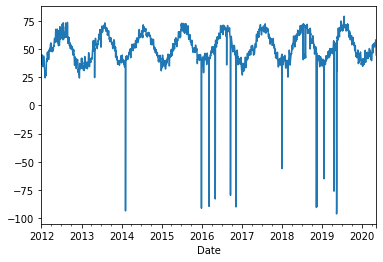

In [18]:
series = temp_index["Weighted Temp"]
series.plot()
#plt.savefig("TempIndex.png")
plt.show()

Identify all outliers that fall more than two standard deviations below the mean and remove them.

In [19]:
outliers = temp_index["Weighted Temp"] < temp_index["Weighted Temp"].mean() - 2*temp_index["Weighted Temp"].std()
index = [i for i, val in enumerate(outliers) if val]

In [20]:
for value in index:
    temp_index["Weighted Temp"][value] =  temp_index["Weighted Temp"][value-5] 

Plot the data again and look for peculiarities.

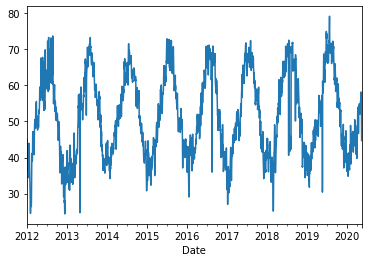

In [21]:
series = temp_index["Weighted Temp"]
series.plot()
#plt.savefig("TempIndex.png")
plt.show()

In [22]:
write_index2_path = Path("__file__").parent.joinpath("Manipulated_Data", "Weather_Data").parent.joinpath("Weather_Data", "Temperature Index 2.csv")
temp_index.to_csv(write_index2_path)